# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [118]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

MAX_FEATURES = 8000

## Implementation work

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [45]:
train = pd.read_csv('./data/train_preprocessed50k.csv')
test = pd.read_csv('./data/test_preprocessed50k.csv')

Please choose one of the following vectorizers:
#### Creating regular CountVectorizers (default)

In [43]:
titleVectorizer = CountVectorizer(max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(max_features=MAX_FEATURES)

#### Creating 1-hot vectors

In [14]:
titleVectorizer = CountVectorizer(binary=True, max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(binary=True, max_features=MAX_FEATURES)

#### Creating TF-IDF vectors

In [ ]:
titleVectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(max_features=MAX_FEATURES)

#### Creating bi-gram CountVectorizors

In [21]:
titleVectorizer = CountVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)

#### Creating bi-gram TF-IDF vectors

In [46]:
titleVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)

#### Creating tri-gram CountVectorizors

In [27]:
titleVectorizer = CountVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)

#### Creating tri-gram TF-IDF vectors

In [ ]:
titleVectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)

#### Transforming the dataset

In [47]:
trainTitleArr = list(map(str, train['review_title']))
trainTextArr = list(map(str, train['review_text']))

titleWords = titleVectorizer.fit_transform(trainTitleArr).toarray()
textWords = textVectorizer.fit_transform(trainTextArr).toarray()

allWords = np.array([np.concatenate((titleWords[i], textWords[i])) for i in range(len(titleWords))])

print(titleWords.shape)
print(textWords.shape)
print(allWords.shape)

y = train['class_index']

# Test variables
testTitleArr = list(map(str, test['review_title']))
testTextArr = list(map(str, test['review_text']))

testTitleVector = titleVectorizer.transform(testTitleArr).toarray()
testTextVector = textVectorizer.transform(testTextArr).toarray()

testAllWords = np.array([np.concatenate((testTitleVector[i], testTextVector[i])) for i in range(len(testTitleVector))])

(50000, 8000)
(50000, 8000)
(50000, 16000)


### Training Classifiers and Prediction

In [48]:
def predict(clf, **arg):
    # Train with allWords
    clf.fit(allWords, y, **arg)

    return clf.predict(testAllWords)

### Splitting in 3 datasets: Train, Parameter Fine-Tuning and Test.

In [49]:
def fullPredict(clf, param_grid, **arg):
    # Splitting test dataset into test and parameter fine tuning
    X_train, X_paramTuning, y_train, y_paramTuning= train_test_split(allWords, y, test_size=0.3, random_state=0)
    
    # Train with allWords
    clf.fit(X_train, y_train, **arg)

    grid = HalvingGridSearchCV(clf, param_grid) # If we want Cross Validation: cv=pdfsplt

    grid.fit(X_paramTuning, y_paramTuning, **arg)

    print("Best grid params:", grid.best_params_)

    return grid.predict(testAllWords)

# MultinomialNB()

### Plot Results

In [107]:
def prepare_statistic(data):
    x = ['Accuracy', 'Precision', 'Recall', 'F1']
    title = data.iloc[0]
    y = data.iloc[1:].tolist()
    return x, y, title

def plot_all_metrics(data, figLabel):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
    fig.set_figwidth(20)
    fig.set_figheight(7)
    fig.suptitle(figLabel)
    for i in range(2):
        for j in range(3):
            index = i*3 + j
            currData = data[index]
            x, y, title = prepare_statistic(currData)
            axis = axs[i, j]
            # axis.set_ylim(bottom=0.0, top=1.0)    # Uncomment this to see yAxis from [0, 1]
            axis.bar(x, y)
            axis.set_title(title)
            axis.grid(True)
    plt.show()

def plot_bar(x, y, title, y_label, x_label):
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,1.5])
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.show()

### Analyze Results

In [114]:
def analyze(prediction, test, classifierLabel):
    y_test = test['class_index']

    # confusion matrix
    confusionMatrix = confusion_matrix(y_test, prediction)
    print("Confusion Matrix:")
    print(confusionMatrix)

    plot_data = []

    # Accuracy is a metric that takes into account all the classes
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='weighted')
    recall = recall_score(y_test, prediction, average='weighted')
    f1 = f1_score(y_test, prediction, average='weighted')

    print("Accuracy: ", accuracy * 100, " %")
    print("Precision: ", precision * 100, " %")
    print('Recall: ', recall * 100, " %")
    print('F1: ', f1 * 100, " %")

    plot_data.append(pd.Series(['All Ratings', accuracy, precision, recall, f1]))
    
    # Calculate metrics for individual classes
    for class_index in range(1, 6, 1):
        precision = precision_score(y_test, prediction, average='weighted', labels=[class_index])
        recall = recall_score(y_test, prediction, average='weighted', labels=[class_index])
        f1 = f1_score(y_test, prediction, average='weighted', labels=[class_index])
        plot_data.append(pd.Series([str(class_index)+' Star Rating', accuracy, precision, recall, f1]))


    # Plot the data
    plot_all_metrics(plot_data, classifierLabel)

    return accuracy


### K-Nearest Neighbor

K-Nearest Neighbor Results:
Confusion Matrix:
[[1024  400  180  102  294]
 [ 645  526  335  147  347]
 [ 325  409  558  301  407]
 [ 219  176  358  492  755]
 [ 156  117  175  379 1173]]
Accuracy:  37.730000000000004  %
Precision:  36.86362125178842  %
Recall:  37.730000000000004  %
F1:  36.54612972997667  %


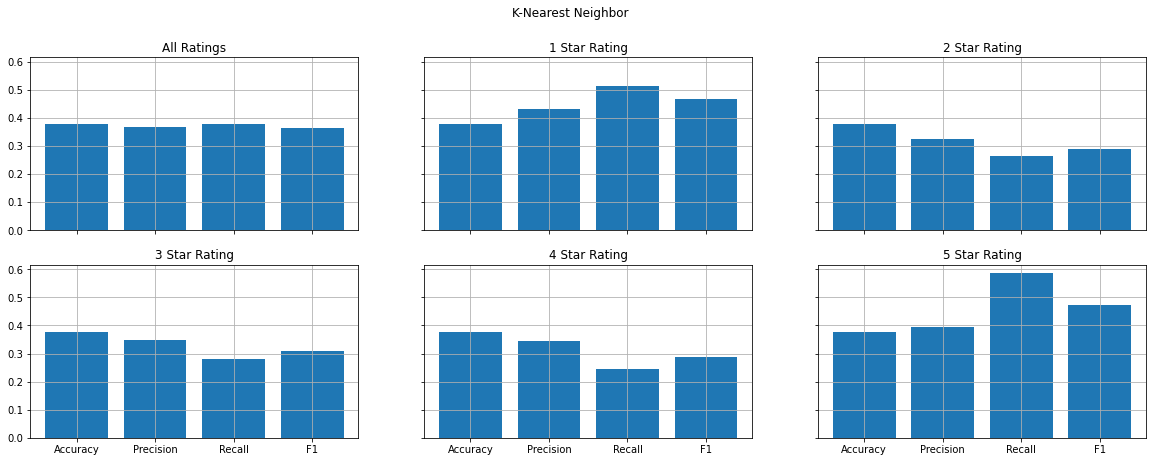

In [115]:
begin = time.time()
prediction = predict(KNeighborsClassifier(n_neighbors=5))
end = time.time()
# prediction = fullPredict(KNeighborsClassifier(), {"n_neighbors": [5, 15, 30, 40], "leaf_size": [10, 20, 30, 35]})
print("K-Nearest Neighbor Results:")
accuracy = analyze(prediction, test, "K-Nearest Neighbor")
knn_metrics = (accuracy, end - begin)

### Multinomial Naive Bayes

MultinomialNB Results:
Confusion Matrix:
[[1307  431  126   64   72]
 [ 519  829  457  123   72]
 [ 211  381  841  427  140]
 [  83   90  368  893  566]
 [  72   54   72  410 1392]]
Accuracy:  52.62  %
Precision:  51.97142801131355  %
Recall:  52.62  %
F1:  52.1833843820949  %


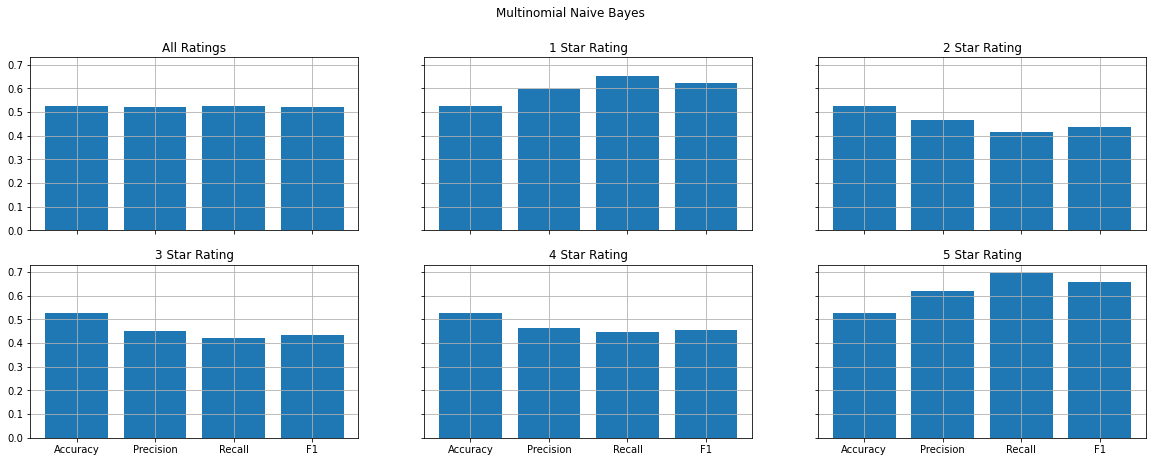

In [117]:
begin = time.time()
prediction = predict(MultinomialNB(), sample_weight=1.0)
end = time.time()
# prediction = gridPredict(MultinomialNB(), {"alpha": [0.0001, 0.5, 1.0]}, sample_weight=1.0)
# prediction = fullPredict(MultinomialNB(), {"alpha": [0.0001, 0.5, 1.0]}, sample_weight=1.0)
print("MultinomialNB Results:")
accuracy = analyze(prediction, test, 'Multinomial Naive Bayes')
nb_metrics = (accuracy, end - begin)

### Random Forest

RandomForestClassifier Results:
Confusion Matrix:
[[1326  348  127   68  131]
 [ 663  640  451  112  134]
 [ 298  386  800  298  218]
 [ 115  155  441  641  648]
 [ 103   82  125  296 1394]]
Accuracy:  48.010000000000005  %
Precision:  46.864309395137354  %
Recall:  48.010000000000005  %
F1:  46.80732871781227  %


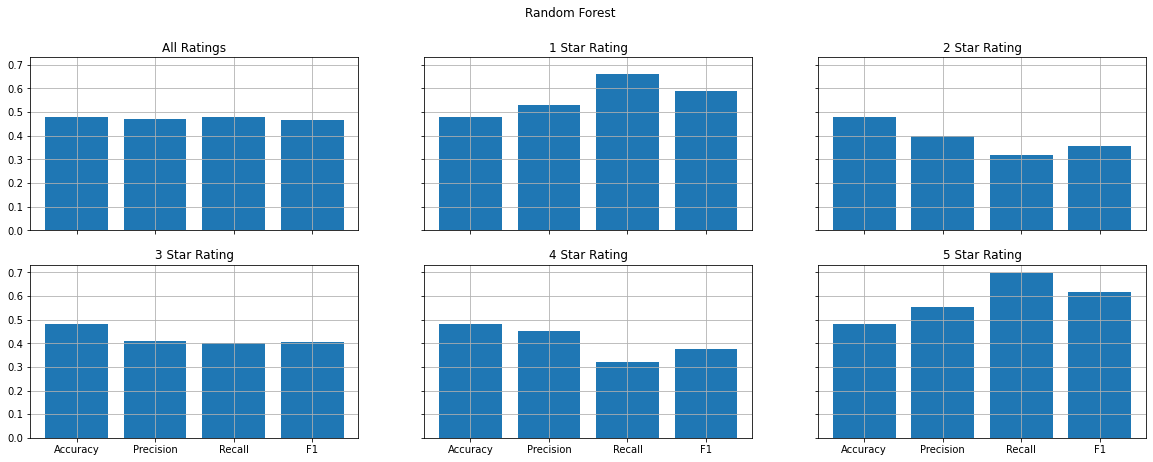

In [95]:
begin = time.time()
prediction = predict(RandomForestClassifier(n_estimators=100), sample_weight=1.0) 
#prediction = fullPredict(RandomForestClassifier(), {"n_estimators": [50, 100]} , sample_weight=1.0)
end = time.time()

print("RandomForestClassifier Results:")
accuracy = analyze(prediction, test, 'Random Forest')
rforest_metrics = (accuracy, end - begin)

### Decision Tree

In [ ]:
begin = time.time()
prediction = predict(DecisionTreeClassifier(), sample_weight=1.0)
# prediction = fullPredict(DecisionTreeClassifier(), {"criterion": ["gini", "entropy", "log_loss"], "splitter": ["best", "random"]} , sample_weight=1.0)
end = time.time()

print("DecisionTreeClassifier Results:")
accuracy = analyze(prediction, test, 'Decision Tree')
dtree_metrics = (accuracy, end - begin)

/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warning

Best grid params: {'criterion': 'gini', 'splitter': 'best'}
DecisionTreeClassifier Results:
Confusion Matrix:
[[83 53 22 23 19]
 [55 43 47 33 22]
 [34 41 54 46 25]
 [17 23 49 58 53]
 [13 24 18 48 97]]
Accuracy:  33.5  %
Precision:  33.13434991037683  %
Recall:  33.5  %
F1:  33.289532259516896  %


### Perceptron

In [23]:
begin = time.time()
prediction = predict(Perceptron(), sample_weight=1.0)
# prediction = fullPredict(Perceptron(), {"alpha": [0.0001, 0.001]} , sample_weight=1.0)
end = time.time()

print("Perceptron Results:")
accuracy = analyze(prediction, test, 'Perceptron')
perceptron_metrics = (accuracy, end - begin)

Best grid params: {'alpha': 0.0001}
Perceptron Results:
Confusion Matrix:
[[109  45  27   9  10]
 [ 51  80  30  30   9]
 [ 27  49  53  49  22]
 [ 21  16  27  83  53]
 [ 13  14  17  48 108]]
Accuracy:  43.3  %
Precision:  42.86348551441378  %
Recall:  43.3  %
F1:  42.935683522677394  %


### Logistic Regression

In [10]:
begin = time.time()
prediction = predict(LogisticRegression(), sample_weight=1.0)
# Best grid params: {'class_weight': 'balanced', 'solver': 'saga'} este foi o resultado do grid search
#prediction = fullPredict(LogisticRegression(), {#"penalty": ["l1", "l2", "elastic", "none"],
#    "class_weight": ["balanced", None], "solver": ["newton-cg", "lbfgs", "sag", "saga"]
#}, sample_weight=1.0)
end = time.time()

print("LogisticRegression Results:")
accuracy = analyze(prediction, test, 'Logistic Regression')
logregression_metrics = (accuracy, end - begin)

LogisticRegression Results:
Confusion Matrix:
[[121  41  22   7   9]
 [ 52  76  37  27   8]
 [ 28  48  60  43  21]
 [ 15  10  39  85  51]
 [  6  15  16  43 120]]
Accuracy:  46.2  %
Precision:  45.57338914038485  %
Recall:  46.2  %
F1:  45.8121814558217  %


/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Linear SVC

In [ ]:
begin = time.time()
prediction = predict(LinearSVC(), sample_weight=1.0)
# Best grid params: {'C': 0.2, 'class_weight': 'balanced', 'dual': True, 'loss': 'squared_hinge', 'multi_class': 'ovr'}
#prediction = fullPredict(LinearSVC(), {
#    "class_weight": ["balanced", None], "loss": ["hinge", "squared_hinge"], "multi_class": ["ovr", "crammer_singer"], "C": [0.2, 0.5, 1.0, 2.0], "dual": [True, False]
#}, sample_weight=1.0)
end = time.time()

print("LinearSVC Results:")
accuracy = analyze(prediction, test, 'Linear SVC')
linearSVC_metrics = (accuracy, end - begin)

### Neural Network (Multi-Layer Perceptron)

In [ ]:
begin = time.time()
prediction = predict(MLPClassifier())
end = time.time()

print("NeuralNetwork Results:")
accuracy = analyze(prediction, test, 'Neural Network (Multi-Layer Perceptron)')
neuralnet_metrics = (accuracy, end - begin)

### Comparing Classifiers

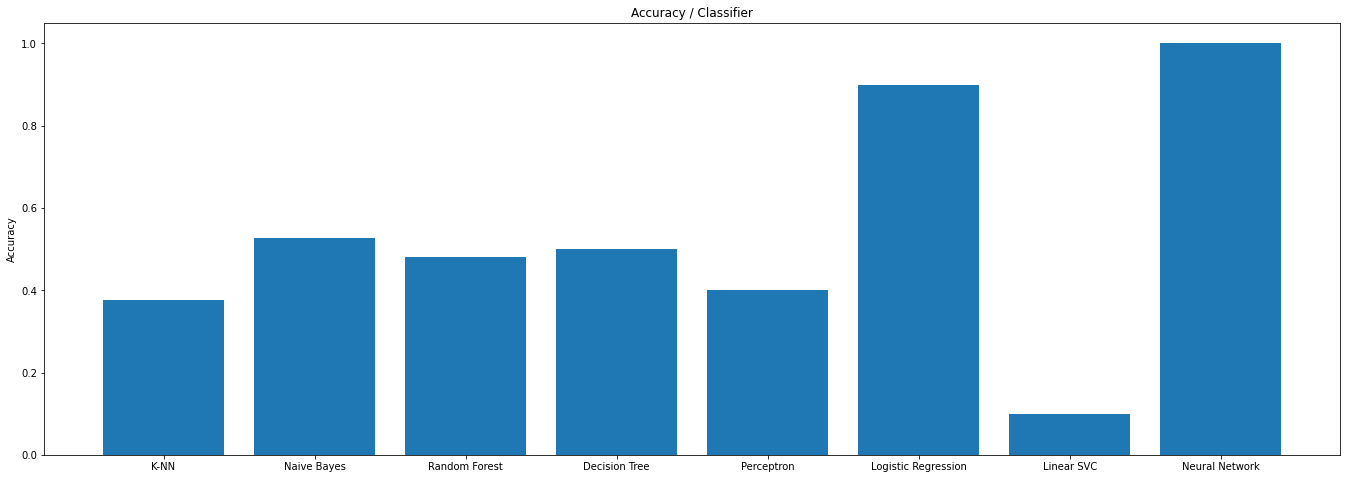

In [119]:
models=['K-NN', 'Naive Bayes', 'Random Forest', 'Decision Tree', 'Perceptron', 'Logistic Regression', 'Linear SVC', 'Neural Network']
accuracies=[knn_metrics[0], nb_metrics[0], rforest_metrics[0], dtree_metrics[0], perceptron_metrics[0], logregression_metrics[0], linearSVC_metrics[0], neuralnet_metrics[0]]
execTimes=[knn_metrics[1], nb_metrics[1], rforest_metrics[1], dtree_metrics[1], perceptron_metrics[1], logregression_metrics[1], linearSVC_metrics[1], neuralnet_metrics[1]]

plot_bar(models, accuracies, 'ML Models Accuracy', 'Accuracy', '')

plot_bar(models, execTimes, 'ML Models Time', 'Time (s)', '')